**Aim**: Predict the outcome of heart attack <br>
Dataset : The dataset is extracted from https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset?sort=published <br>

Features: <br>
- **Age** : Age of the patient <br>
- **Sex** : Sex of the patient <br>
- **cp** : Chest Pain type chest pain type. 0 = Typical Angina, 1 = Atypical Angina, 2 = Non-anginal Pain, 3 = Asymptomatic. <br> 
- **trtbps** : resting blood pressure (in mm Hg) <br>
- **chol** : cholestoral in mg/dl fetched via BMI sensor <br>
- **fbs** : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) <br>
- **rest_ecg** : resting electrocardiographic results. 0= normal, 1 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV),
2 = showing probable or definite left ventricular hypertrophy by Estes' criteria <br>
- **thalach** : maximum heart rate achieved <br>
- **exang** : exercise induced angina (1 = yes; 0 = no) <br>
- **oldpeak** - Previous peak <br>
- **slp** - Slope <br>
- **caa** : number of major vessels (0-3) <br>
- **thall** - Thalium Stress Test result ~ (0,3) <br>
- **output** : 0= less chance of heart attack 1= more chance of heart attack

## Table of Contents
- [1. Import Packages](#1)
- [2. Load Data](#2)
- [3. Exploratory Data Analysis](#3)
- [4. Data Preprocessing](#4)
- [5. Modelling](#5)

<a name='1'></a>
## 1.  Import Packages

In [181]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier


<a name='2'></a>
## 2. Load Data

In [172]:
df = pd.read_csv('Data/heart.csv')

<a name='3'></a>
##  3. Exploratory Data Analysis

In [173]:
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.30,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.50,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.40,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.80,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.60,2,0,2,1


In [174]:
df.rename(columns = {"cp":"ChestPainType", "trtbps":"RestingBP", "fbs":"FastingBS", "restecg":"RestingECG", "thalachh":"MaxHR", "exng":"ExerciseAngina", "slp":"Slope", "caa":"MajorVessels", "thall":"StressTest"}, inplace=True)

In [175]:
print("The shape of the dataset is : ", df.shape)

The shape of the dataset is :  (303, 14)


In [176]:
df.dtypes

age                 int64
sex                 int64
ChestPainType       int64
RestingBP           int64
chol                int64
FastingBS           int64
RestingECG          int64
MaxHR               int64
ExerciseAngina      int64
oldpeak           float64
Slope               int64
MajorVessels        int64
StressTest          int64
output              int64
dtype: object

In [177]:
categorical_cols = ['sex','ChestPainType','ExerciseAngina','Slope','MajorVessels','StressTest']
continuous_cols = ["age",'RestingBP','chol', 'FastingBS', 'RestingECG', 'MaxHR','oldpeak']
target_col = ["output"]
print("The categorial cols are : ", categorical_cols)
print("The continuous cols are : ", continuous_cols)
print("The target variable is :  ", target_col)

The categorial cols are :  ['sex', 'ChestPainType', 'ExerciseAngina', 'Slope', 'MajorVessels', 'StressTest']
The continuous cols are :  ['age', 'RestingBP', 'chol', 'FastingBS', 'RestingECG', 'MaxHR', 'oldpeak']
The target variable is :   ['output']


#### count plot for categorical features

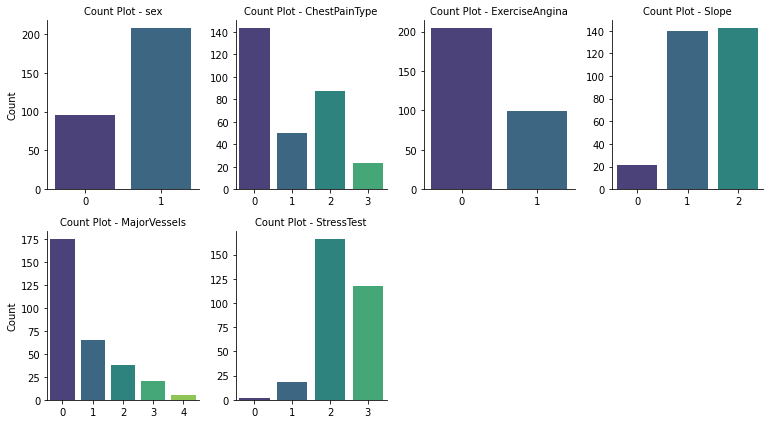

In [178]:
g = sns.catplot(
    data=df[categorical_cols].melt(),
    x="value",
    col="variable",
    kind="count",
    col_wrap=4,
    palette="viridis",
    height=3,
    aspect=0.9,
    sharex=False,
    sharey=False,
)

# Set titles and labels for each plot
g.set_titles("Count Plot - {col_name}")
g.set_xlabels("")
g.set_ylabels("Count")

plt.tight_layout()
plt.show()


#### Histogram and pairwise correlation of continuous features

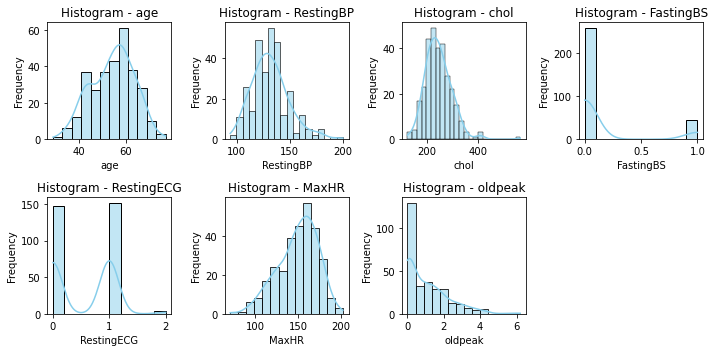

<Figure size 720x360 with 0 Axes>

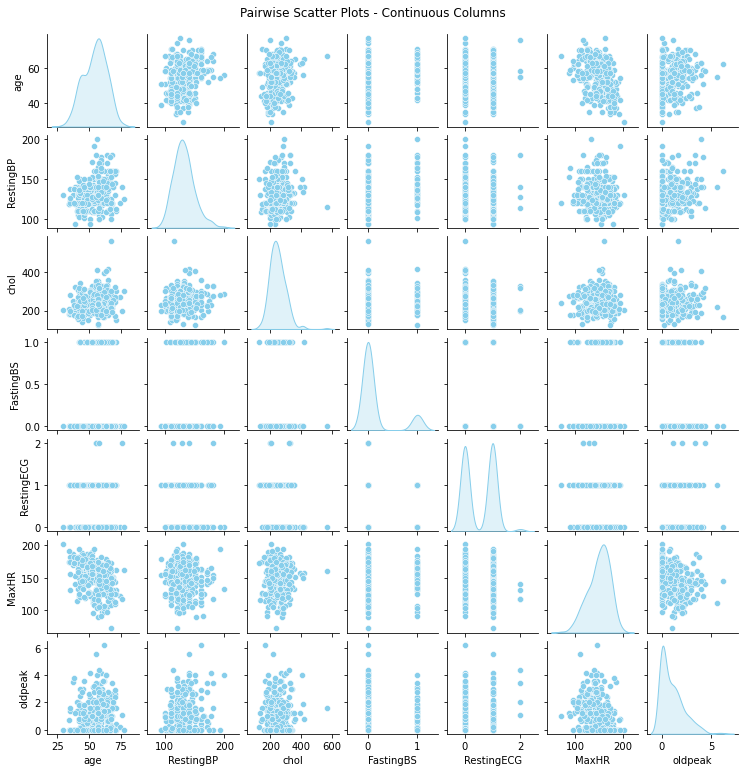

In [179]:
# Plot histogram for each continuous column
plt.figure(figsize=(10, 5))
for i, col in enumerate(continuous_cols, 1):
    plt.subplot(2, 4, i)
    sns.histplot(data=df, x=col, kde=True, color='skyblue')
    plt.title(f"Histogram - {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Plot scatter plot for pairwise continuous columns
plt.figure(figsize=(10, 5))
sns.pairplot(df[continuous_cols], diag_kind="kde", plot_kws={"color": "skyblue"}, diag_kws={"color": "skyblue"}, height=1.5)
plt.suptitle("Pairwise Scatter Plots - Continuous Columns", y=1.02)
plt.show()


#### Correlation Matrix

Dark orange/red represents positive correlation <br>
dark blue represents negative correlation

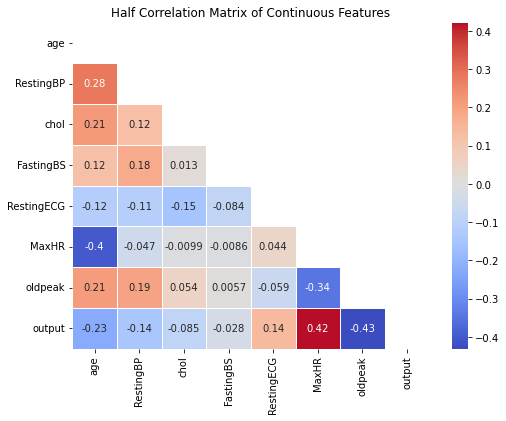

In [180]:
# Compute the correlation matrix
correlation_matrix = df[continuous_cols+ target_col].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, linewidths=0.5, mask=mask)
plt.title("Half Correlation Matrix of Continuous Features")
plt.show()

The output label has a high positive correlation with "MaxHR" and high negative correlation with old peak. 

#### Distribution of features by the output label

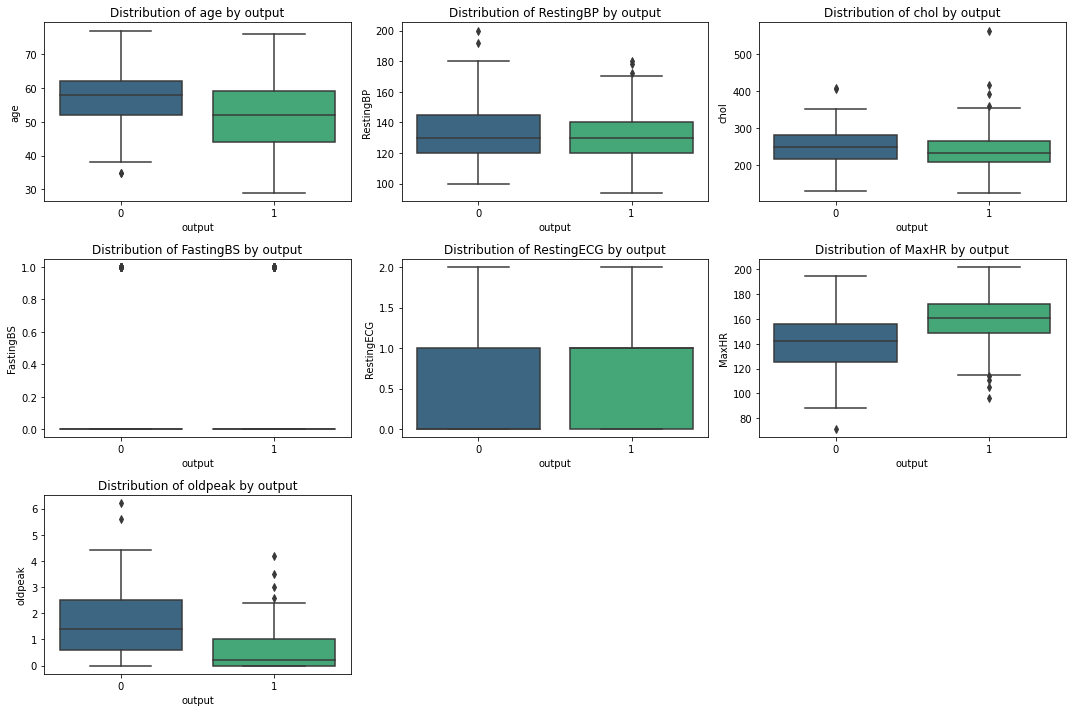

In [100]:
# Separate data by output
df_cont = df[continuous_cols + target_col].copy()
df_outcome_0 = df_cont[df_cont["output"] == 0]
df_outcome_1 = df_cont[df_cont["output"] == 1]

# Plot distribution for each column by outcome using boxplots
plt.figure(figsize=(15, 10))
for i, col in enumerate(continuous_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x="output", y=col, data=df_cont, palette="viridis")
    plt.title(f"Distribution of {col} by output")
    plt.xlabel("output")
    plt.ylabel(col)
plt.tight_layout()
plt.show()

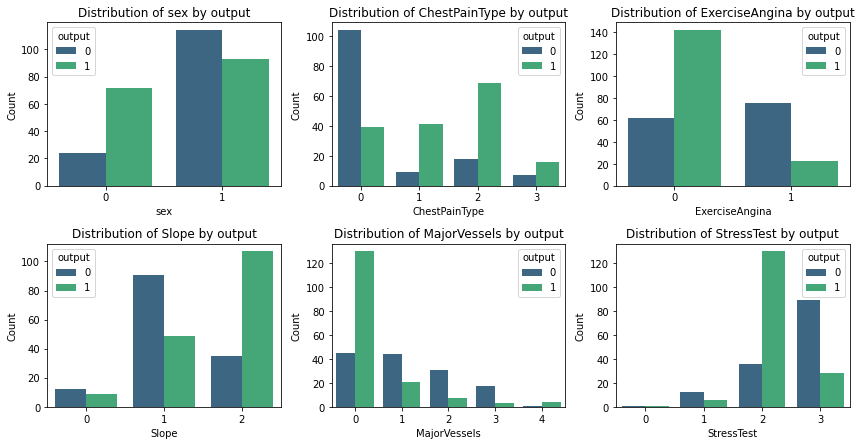

In [101]:
# Plot count plot for each categorical column by outcome
plt.figure(figsize=(12, 12))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(4, 3, i)
    sns.countplot(x=col, hue='output', data=df, palette='viridis')
    plt.title(f'Distribution of {col} by output')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend(title='output', labels=['0', '1'])
plt.tight_layout()
plt.show()

#### Pairplot by output label

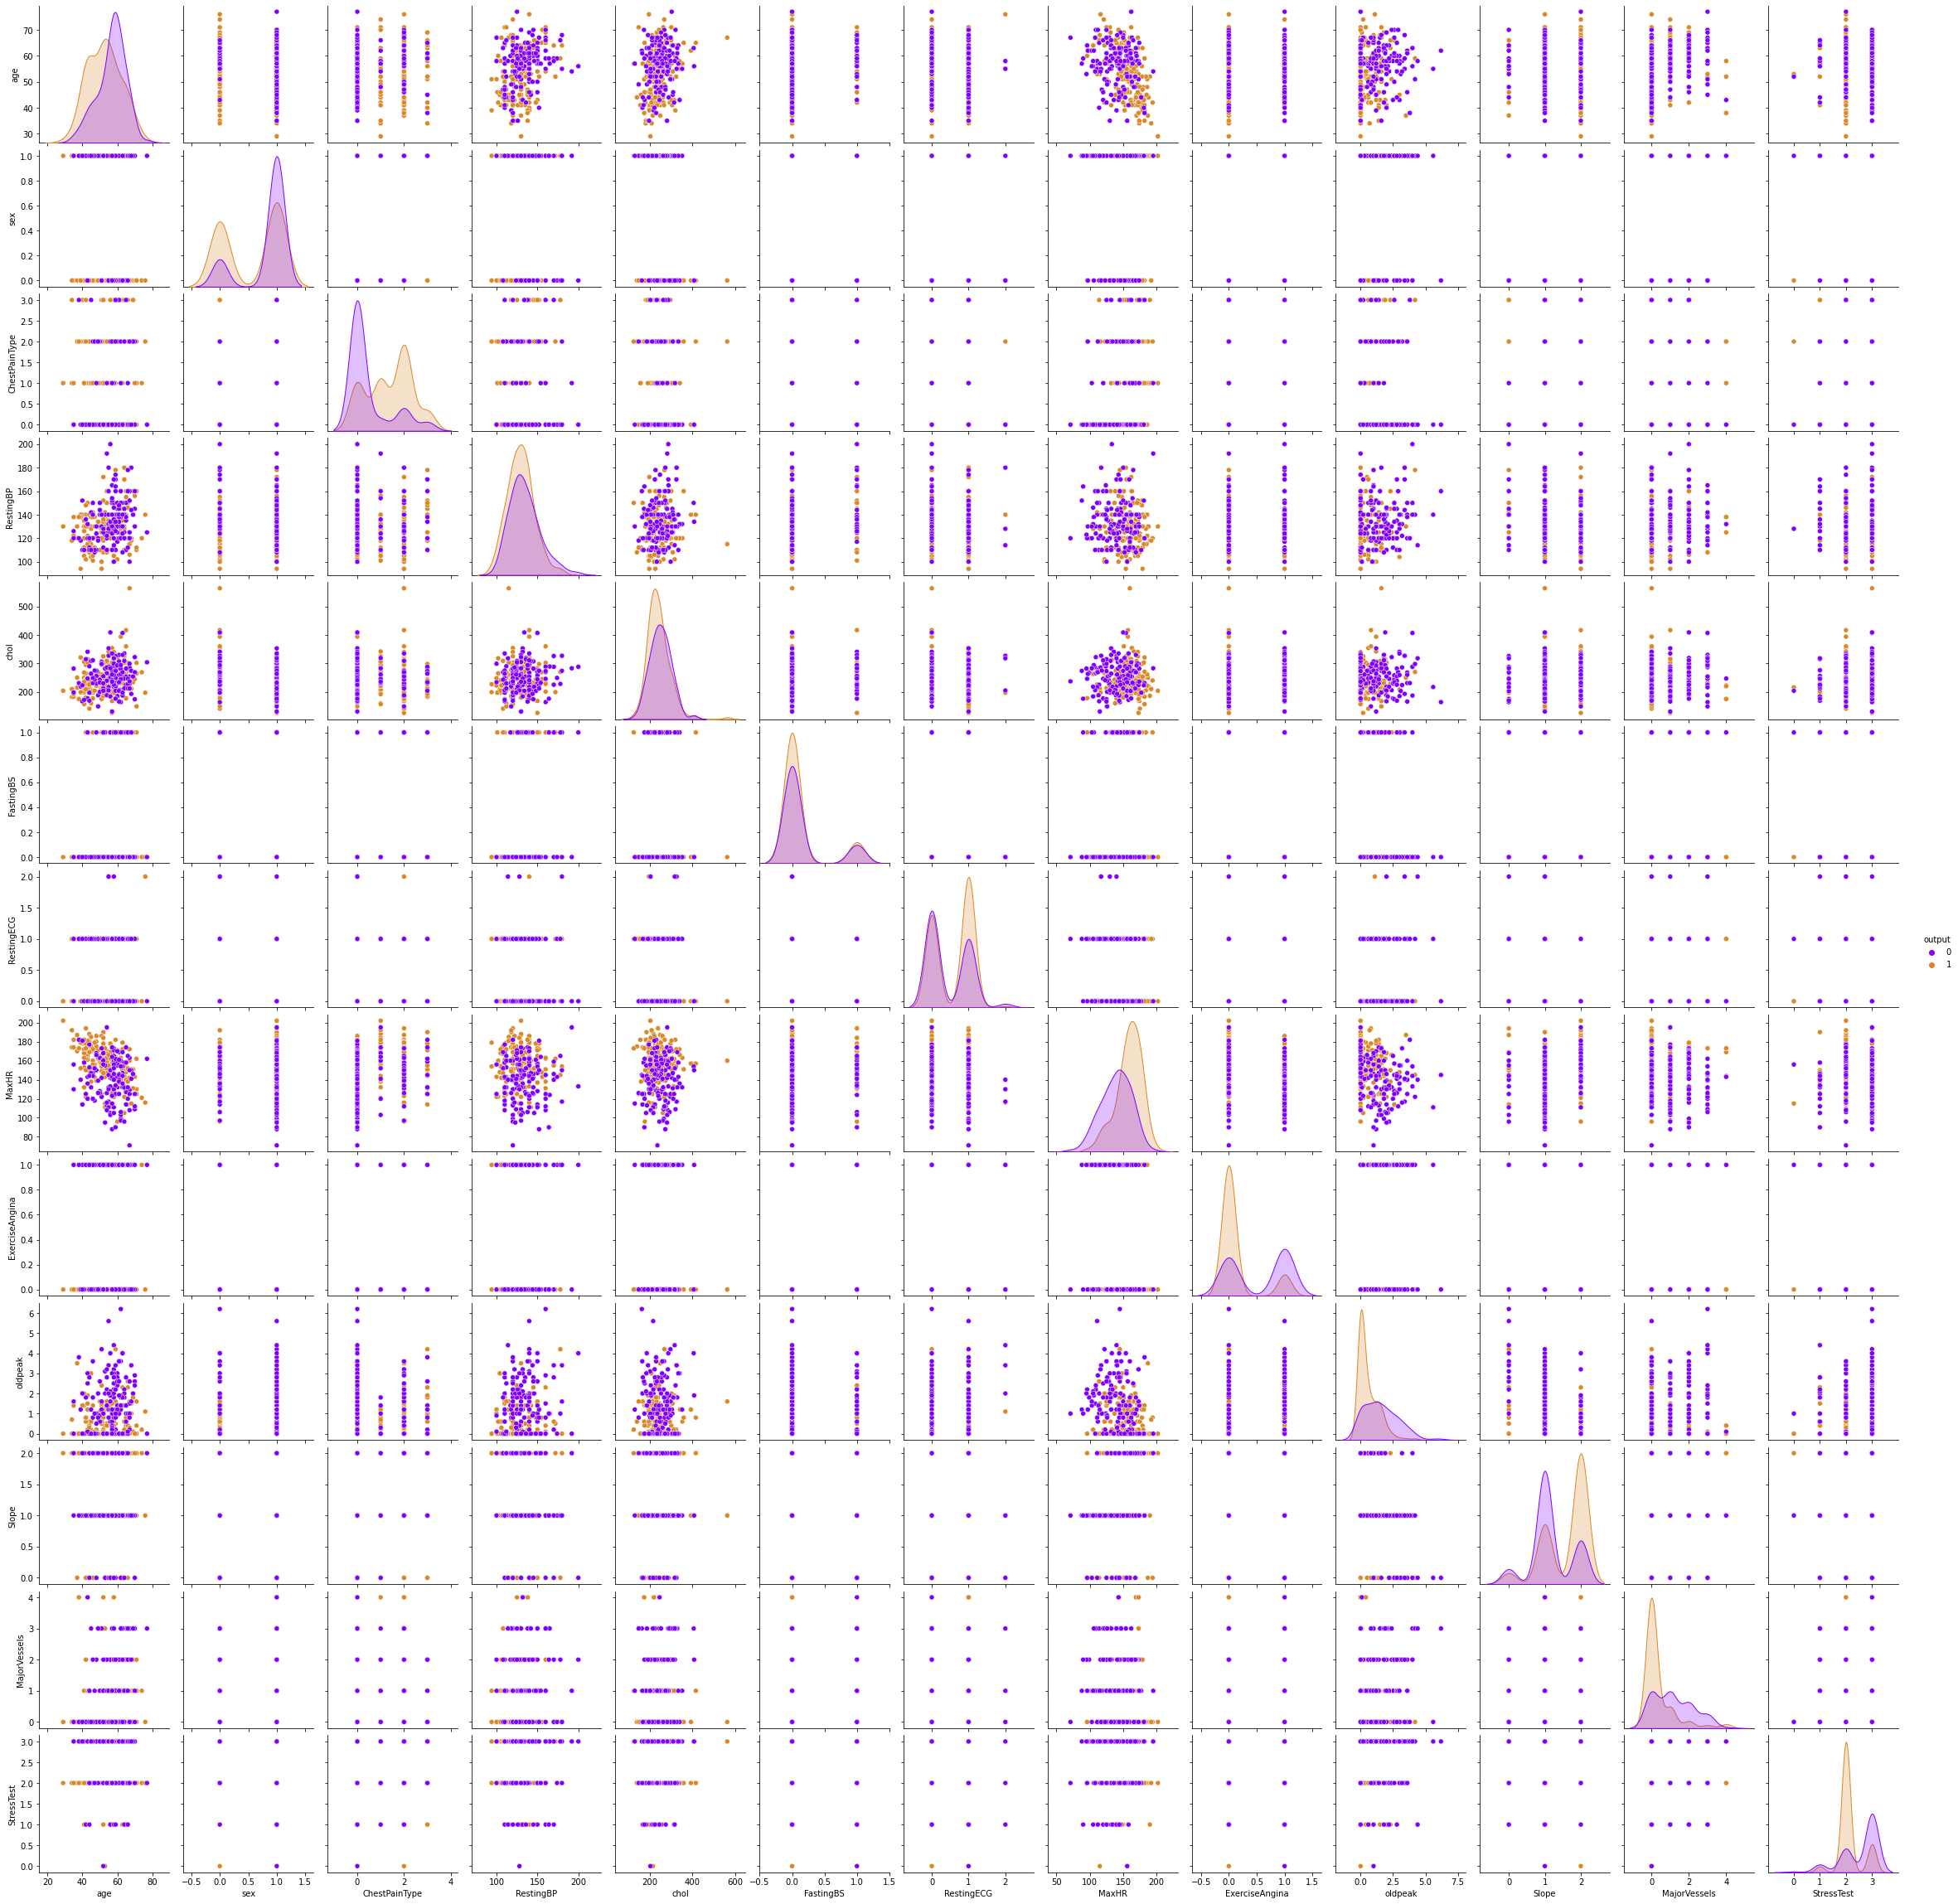

In [102]:
sns.pairplot(df,hue='output',palette = ["#8000ff","#da8829"])
plt.show()

<a name='4'></a>
##  4. Data Preprocessing

In [103]:
# from sklearn.preprocessing import RobustScaler

In [104]:
# checking for Nulls
df.isnull().sum()

age               0
sex               0
ChestPainType     0
RestingBP         0
chol              0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
oldpeak           0
Slope             0
MajorVessels      0
StressTest        0
output            0
dtype: int64

#### Split data into train and test

In [188]:
#defining the features and target
X = df.drop('output', axis=1)  # Drop the target column from features
y = df['output']  #target column

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Shape for training data', X_train.shape, y_train.shape)
print('Shape for testing data', X_test.shape, y_test.shape)

Shape for training data (212, 13) (212,)
Shape for testing data (91, 13) (91,)


#### Encode and scale data

In [189]:
# encoding the categorical columns
encoded_train = pd.get_dummies(X_train, columns = categorical_cols, drop_first = True)
encoded_test = pd.get_dummies(X_test, columns = categorical_cols, drop_first = True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(encoded_train)
X_test_scaled = scaler.transform(encoded_test)



<a name='5'></a>
## 5. Modelling

#### Logistic regression

In [190]:
model = LogisticRegression(random_state = 0)
model.fit(X_train_scaled, y_train)
predicted = model.predict(X_test_scaled)
print(model)

print ("The accuracy of Logistic Regression is : ", accuracy_score(y_test, predicted)*100, "%")

LogisticRegression(random_state=0)
The accuracy of Logistic Regression is :  87.91208791208791 %


#### Hyperparameter tuning

In [191]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'fit_intercept': [True, False],
    'class_weight': [None, 'balanced'],
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
    'max_iter': [100, 500, 1000]
}

model = LogisticRegression(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)



Best Parameters: {'C': 1, 'class_weight': None, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.8791208791208791


#### KNeighborsClassifier

In [200]:
k_values = list(range(1, 21))
accuracy_scores = []
f1_scores = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)

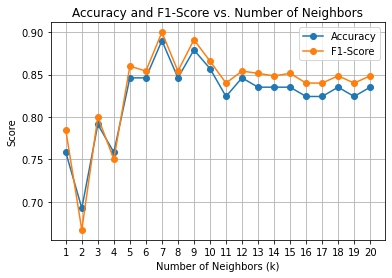

In [193]:
# Plot the results
plt.plot(k_values, accuracy_scores, marker='o', label='Accuracy')
plt.plot(k_values, f1_scores, marker='o', label='F1-Score')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Score')
plt.title('Accuracy and F1-Score vs. Number of Neighbors')
plt.xticks(k_values)
plt.grid(True)
plt.legend()
plt.show()


In [204]:
k_best = 7  # Number of neighbors
index_best_k = k_best - 1 
accuracy_best_k = accuracy_scores[index_best_k]
f1_best_k = f1_scores[index_best_k]

print("Accuracy when k =", k_best, ":", accuracy_best_k)
print("F1 Score when k =", k_best, ":", f1_best_k)


Accuracy when k = 7 : 0.8901098901098901
F1 Score when k = 7 : 0.9
